In [1]:
import tensorflow as tf
from tensorflow import convert_to_tensor, string
from tensorflow.keras.layers import TextVectorization, Embedding, Layer
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import keras
import logging
import warnings
warnings.filterwarnings("ignore")

In [2]:
from transformers import AutoModelForSequenceClassification
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer # T5ForConditionalGeneration # RobertaTokenizer

In [3]:
id2label = {0: "CORRECT", 1: "BUGGY"}
label2id = {"CORRECT": 0, "BUGGY": 1}

In [4]:
model_name = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id)

tokenizers = AutoTokenizer.from_pretrained('dipudl/codet5-base')

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Downloading:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/276k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/148k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.01k [00:00<?, ?B/s]

In [5]:
df = pd.read_csv('/kaggle/input/finalized-csv/finalized.csv')
df = df.iloc[:,1:]
df

,labels,full_text
0,0,__builtin_bfin_compose_2x16 0x3000 0x2000 int ...
1,1,__builtin_bfin_compose_2x16 0x2000 0x3000 int ...
2,0,__builtin_bfin_compose_2x16 0x7000 0x5000 int ...
3,1,__builtin_bfin_compose_2x16 0x5000 0x7000 int ...
4,0,foo0000 a b fract2x16 a b
...,...,...
52021,1,strcmp visual opt int __s1 __s2
52022,0,strcmp opt normal int __s1 __s2
52023,1,strcmp normal opt int __s1 __s2
52024,0,strcmp opt off int __s1 __s2


In [6]:
a = "setDimension width height int x y"
b = "swap &first &second char* x y"

In [7]:
output_sequence_length = 10
vocab_size = 30
sentences = [a, b]
sentence_data = tf.data.Dataset.from_tensor_slices(sentences)


vectorize_layer = TextVectorization(
                  output_sequence_length=output_sequence_length,
                  max_tokens=vocab_size,
)

vectorize_layer.adapt(sentence_data)

word_tensors = convert_to_tensor(sentences, dtype=tf.string)

vectorized_words = vectorize_layer(word_tensors)
print("Vocabulary: ", vectorize_layer.get_vocabulary())


Vocabulary:  ['', '[UNK]', 'y', 'x', 'width', 'swap', 'setdimension', 'second', 'int', 'height', 'first', 'char']


In [8]:
print("Vectorized words: ", vectorized_words)

Vectorized words:  tf.Tensor(
[[ 6  4  9  8  3  2  0  0  0  0]
 [ 5 10  7 11  3  2  0  0  0  0]], shape=(2, 10), dtype=int64)


In [9]:
output_length = 10
word_embedding_layer = Embedding(vocab_size, output_length)
embedded_words = word_embedding_layer(vectorized_words)
print(embedded_words)

tf.Tensor(
[[[-0.01117767  0.02537832 -0.04929385  0.00415676 -0.00399445
   -0.00084106  0.01835853  0.04709684 -0.00806974 -0.04930239]
  [-0.00524896  0.03510452  0.00670649 -0.04970333  0.04138016
   -0.01728851 -0.02164732 -0.03133875  0.00852344 -0.04782009]
  [-0.0352824   0.04228613  0.04910203 -0.04690207  0.03981651
   -0.00732938 -0.04615832 -0.04788958  0.01284187 -0.02835834]
  [ 0.00148375 -0.03121423 -0.02540233 -0.02982967  0.0382621
   -0.01968632 -0.02855557  0.03725595 -0.00486537 -0.04347724]
  [ 0.0471541   0.03687273 -0.0451311  -0.03487188  0.03789899
    0.0257496   0.01093047 -0.00863729 -0.02399142  0.0425781 ]
  [-0.02334083 -0.01208331  0.01009933  0.00411183 -0.00845252
    0.01103376 -0.04637126 -0.04291978 -0.01259794 -0.04452753]
  [-0.00453796  0.00032955  0.01199672  0.02936314 -0.01342158
    0.01129965  0.00896471  0.0034186   0.01829988  0.01764849]
  [-0.00453796  0.00032955  0.01199672  0.02936314 -0.01342158
    0.01129965  0.00896471  0.0034186 

In [10]:
embedded_words.shape

TensorShape([2, 10, 10])

In [11]:
def get_position_encoding(seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P

In [12]:
positional_embedded_indices = get_position_encoding(10,10)
print(positional_embedded_indices)

[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 8.41470985e-01  5.40302306e-01  1.57826640e-01  9.87466836e-01
   2.51162229e-02  9.99684538e-01  3.98106119e-03  9.99992076e-01
   6.30957303e-04  9.99999801e-01]
 [ 9.09297427e-01 -4.16146837e-01  3.11697146e-01  9.50181503e-01
   5.02165994e-02  9.98738351e-01  7.96205928e-03  9.99968302e-01
   1.26191435e-03  9.99999204e-01]
 [ 1.41120008e-01 -9.89992497e-01  4.57754548e-01  8.89078609e-01
   7.52852930e-02  9.97162035e-01  1.19429312e-02  9.99928681e-01
   1.89287090e-03  9.99998209e-01]
 [-7.56802495e-01 -6.53643621e-01  5.92337725e-01  8.05689779e-01
   1.00306487e-01  9.94956586e-01  1.59236138e-02  9.99873211e-01
   2.52382670e-03  9.99996815e-01]
 [-9.58924275e-01  2.83662185e-01  7.12073170e-01  7.02105263e-01
   1.25264396e-01  9.92123395e-01  1.99040441e-02  9.99801895e-01
   3.15478149e-03  9.99995024e-01

In [13]:
final_output_embedding1 = embedded_words[0] + positional_embedded_indices
final_output_embedding2 = embedded_words[1] + positional_embedded_indices
final_output_embedding = tf.concat([final_output_embedding1, final_output_embedding2], axis=0)
final_output_embedding = tf.reshape(final_output_embedding, [2, 10, 10])
print("Final output: ", final_output_embedding)

Final output:  tf.Tensor(
[[[-0.01117767  1.0253783  -0.04929385  1.0041567  -0.00399445
    0.9991589   0.01835853  1.0470968  -0.00806974  0.9506976 ]
  [ 0.836222    0.5754068   0.16453314  0.9377635   0.06649638
    0.982396   -0.01766626  0.9686533   0.0091544   0.95217973]
  [ 0.87401503 -0.37386072  0.3607992   0.9032794   0.09003311
    0.99140894 -0.03819627  0.9520787   0.01410378  0.9716409 ]
  [ 0.14260375 -1.0212067   0.43235222  0.85924894  0.1135474
    0.9774757  -0.01661264  1.0371846  -0.0029725   0.956521  ]
  [-0.7096484  -0.61677086  0.54720664  0.7708179   0.13820548
    1.0207062   0.02685408  0.9912359  -0.02146759  1.042575  ]
  [-0.9822651   0.27157888  0.7221725   0.7062171   0.11681187
    1.0031571  -0.02646722  0.9568821  -0.00944316  0.9554675 ]
  [-0.28395346  0.9604998   0.8259563   0.6102847   0.13672169
    0.99996394  0.03284886  1.0031333   0.02208562  1.0176413 ]
  [ 0.65244865  0.7542318   0.9074397   0.47453943  0.16150583
    0.995881    0.03682

In [14]:
final_output_embedding.shape

TensorShape([2, 10, 10])

# GETTING QWERY KEY AND VALUES FROM DISTILBERT TRANSFORMER 

In [15]:
a = "setDimension width height int x y"
b = "swap &first &second char* x y"

In [16]:
from transformers import DistilBertTokenizer, DistilBertModel

# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
model = DistilBertModel.from_pretrained('distilbert-base-cased')

# Define some input text
input_text = a

# Tokenize the input text and convert it to input IDs
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Pass the input IDs through the model to get the hidden states
outputs = model(input_ids)

# Extract the key, query, and values from the model outputs
key = outputs.last_hidden_state[:, :, :model.config.dim // 2]
query = outputs.last_hidden_state[:, :, model.config.dim // 2:]
values = outputs.last_hidden_state

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
input_ids

tensor([[  101,  1383,  2137, 10453,  2316,  1988,  9346,  3976,  1107,  1204,
           193,   194,   102]])

In [18]:
tokenizer.tokenize(b)

['swap', '&', 'first', '&', 'second', 'ch', '##ar', '*', 'x', 'y']

In [19]:
# Print the shape of each output
print("Key shape:", key.shape)
print("Query shape:", query.shape)
print("Values shape:", values.shape)

Key shape: torch.Size([1, 13, 384])
Query shape: torch.Size([1, 13, 384])
Values shape: torch.Size([1, 13, 768])


In [20]:
print(key)

tensor([[[ 0.3245,  0.2350,  0.0726,  ...,  0.1309,  0.3827,  0.0996],
         [ 0.2059,  0.0948,  0.1881,  ...,  0.3211,  0.6266,  0.1688],
         [-0.1190,  0.0905,  0.1651,  ...,  0.1664,  0.4145,  0.4373],
         ...,
         [ 0.0021,  0.5212,  0.0690,  ...,  0.0249, -0.4229,  0.7241],
         [ 0.2022,  0.3976, -0.0512,  ...,  0.1040, -0.3707,  0.6279],
         [ 0.8549,  0.8328, -0.0198,  ..., -0.1492, -0.3270,  0.0065]]],
       grad_fn=<SliceBackward0>)


In [21]:
print(query)

tensor([[[-1.3460e-01,  1.8201e-01, -9.9229e-02,  ..., -1.1663e-01,
           2.7168e-01,  2.1810e-01],
         [ 5.6914e-02,  2.7122e-01,  1.5995e-01,  ...,  3.0289e-01,
           3.2785e-01,  5.3929e-01],
         [ 6.7564e-04,  3.0385e-01,  1.9323e-01,  ...,  4.0159e-01,
          -1.1362e-01,  1.6101e-01],
         ...,
         [ 1.4683e-01,  1.3298e-01, -1.2111e-01,  ..., -2.2285e-01,
           1.0190e+00,  2.1681e-01],
         [ 3.7348e-01,  1.5002e-01, -2.6370e-01,  ..., -2.0264e-01,
           7.1977e-01,  1.6937e-01],
         [ 3.6671e-01,  2.1213e-01, -4.0603e-01,  ...,  1.5975e-01,
           6.1378e-01, -2.5271e-01]]], grad_fn=<SliceBackward0>)


In [22]:
print(values)

tensor([[[ 0.3245,  0.2350,  0.0726,  ..., -0.1166,  0.2717,  0.2181],
         [ 0.2059,  0.0948,  0.1881,  ...,  0.3029,  0.3279,  0.5393],
         [-0.1190,  0.0905,  0.1651,  ...,  0.4016, -0.1136,  0.1610],
         ...,
         [ 0.0021,  0.5212,  0.0690,  ..., -0.2229,  1.0190,  0.2168],
         [ 0.2022,  0.3976, -0.0512,  ..., -0.2026,  0.7198,  0.1694],
         [ 0.8549,  0.8328, -0.0198,  ...,  0.1597,  0.6138, -0.2527]]],
       grad_fn=<NativeLayerNormBackward0>)


In [23]:
import torch 
import seaborn as sns

In [24]:
def calculate_attention(query, key, value):
    # Calculate dot products between query and keys
    dot_products = torch.matmul(key, query.transpose(-1, -2))
    dk = query.shape[-1]
    
    # Calculate attention weights using softmax
    attention_weights = torch.softmax(dot_products / torch.sqrt(torch.tensor(dk).float()), dim=-1)
    
    # Calculate attention vectors using weighted sum of values
    attention_vectors = torch.matmul(attention_weights, value)
    
    return attention_weights, attention_vectors


In [27]:
attention_weights, attention_vectors = calculate_attention(query, key, values)

In [28]:
print("Attention weights shape:", attention_weights.shape)
print("Attention vectors shape:", attention_vectors.shape)

Attention weights shape: torch.Size([1, 13, 13])
Attention vectors shape: torch.Size([1, 13, 768])


In [29]:
my_token = tokenizer.tokenize(input_text)
my_token.insert(0,'Start')
my_token.append('End')
my_token

['Start',
 'set',
 '##D',
 '##ime',
 '##ns',
 '##ion',
 'width',
 'height',
 'in',
 '##t',
 'x',
 'y',
 'End']

In [30]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Define the softmax function for the attention scores
softmax = torch.nn.Softmax(dim=-1)

# Define the input query, key, and values
batch_size = 1
seq_len = query.shape[1]
query_hidden_size = query.shape[2]
key_hidden_size = key.shape[2]
values_hidden_size = values.shape[2]


# Define the number of heads and the head size
num_heads = 8
head_size = values_hidden_size // num_heads

# Define the linear layers for projection
query_proj = torch.nn.Linear(query_hidden_size, values_hidden_size)
key_proj = torch.nn.Linear(key_hidden_size, values_hidden_size)
value_proj = torch.nn.Linear(values_hidden_size, values_hidden_size)
output_proj = torch.nn.Linear(values_hidden_size, values_hidden_size)

# Split the query, key, and values into multiple heads
query_heads = query_proj(query).view(batch_size, seq_len, num_heads, head_size).transpose(1, 2)  # shape: (batch_size, num_heads, seq_len, head_size)
key_heads = key_proj(key).view(batch_size, seq_len, num_heads, head_size).transpose(1, 2)  # shape: (batch_size, num_heads, seq_len, head_size)
value_heads = value_proj(values).view(batch_size, seq_len, num_heads, head_size).transpose(1, 2)  # shape: (batch_size, num_heads, seq_len, head_size)

# Calculate the attention scores for each head
attention_scores = torch.matmul(query_heads, key_heads.transpose(-2, -1))  # shape: (batch_size, num_heads, seq_len, seq_len)

# Apply the softmax function to get the attention weights for each head
attention_weights = softmax(attention_scores)  # shape: (batch_size, num_heads, seq_len, seq_len)

# Calculate the context vectors for each head
context_vectors = torch.matmul(attention_weights, value_heads)  # shape: (batch_size, num_heads, seq_len, head_size)

# Concatenate the context vectors for each head along the last dimension
multihead_output = context_vectors.transpose(1, 2).contiguous().view(1, seq_len, values_hidden_size)

# Project the output through a linear layer
output = output_proj(multihead_output)  # shape: (batch_size, seq_len, values_hidden_size)

In [31]:
attention_weights.squeeze().shape

torch.Size([8, 13, 13])

In [32]:
len(attention_weights.squeeze().detach().numpy())

8

In [33]:
context_vectors.shape

torch.Size([1, 8, 13, 96])

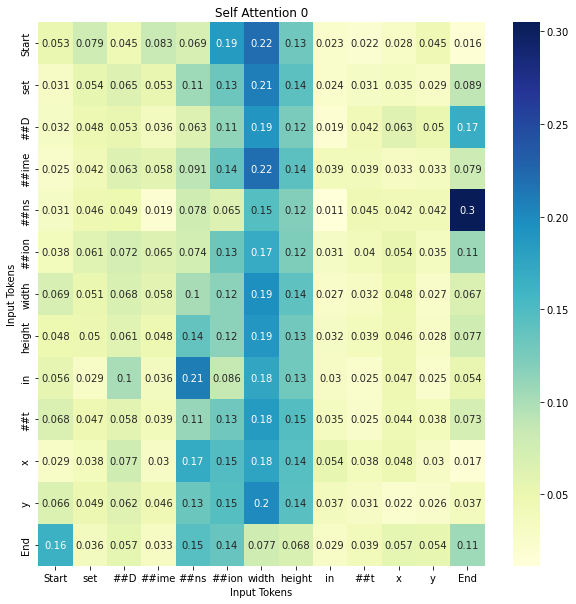

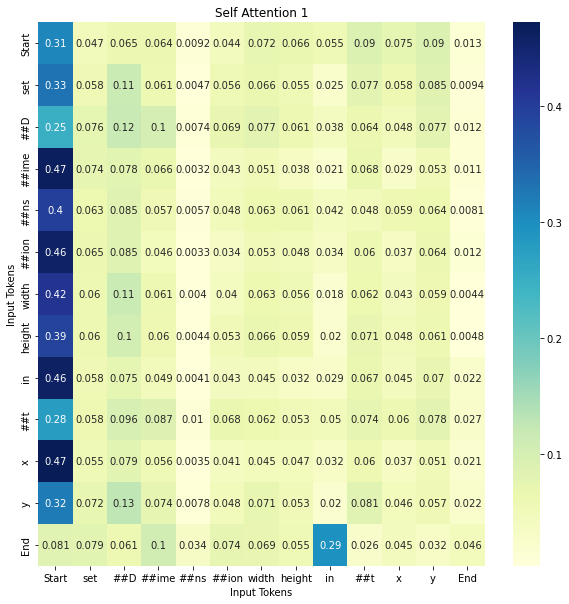

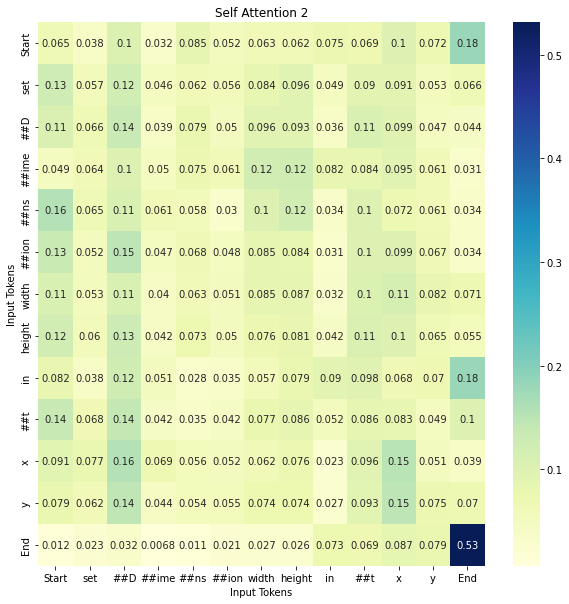

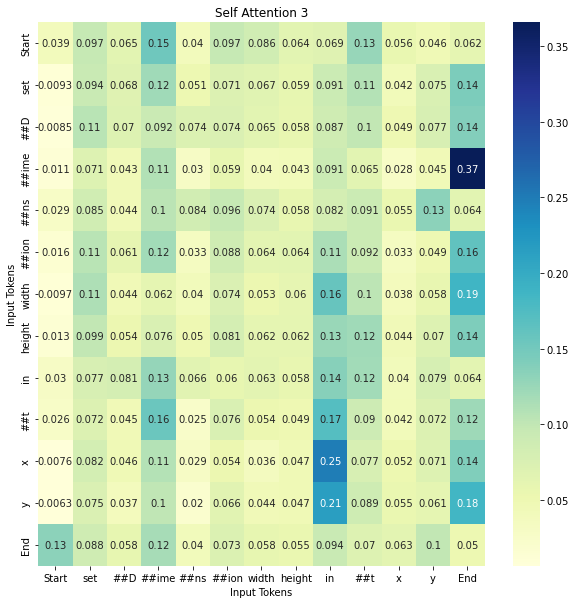

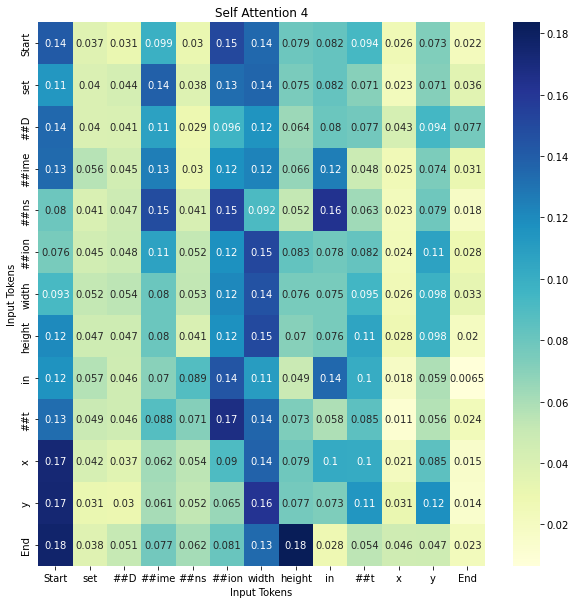

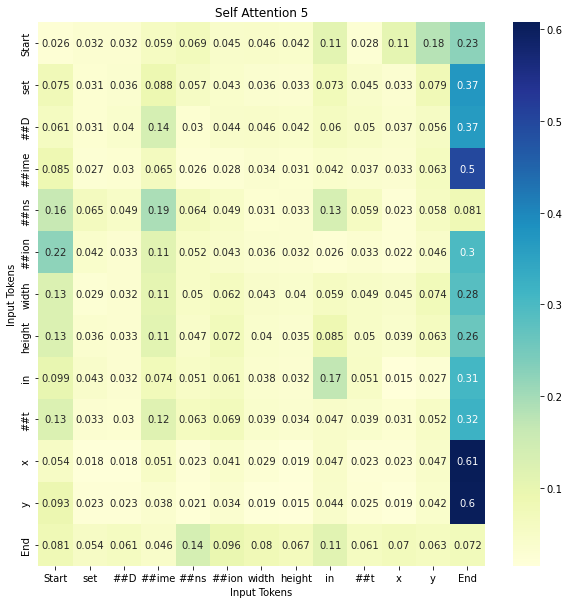

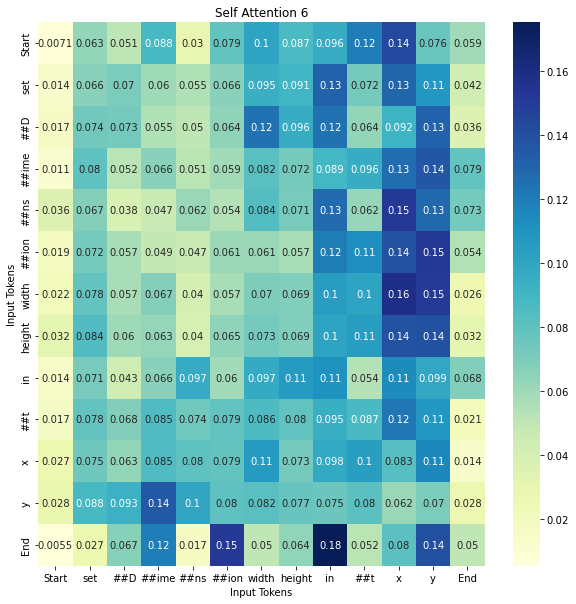

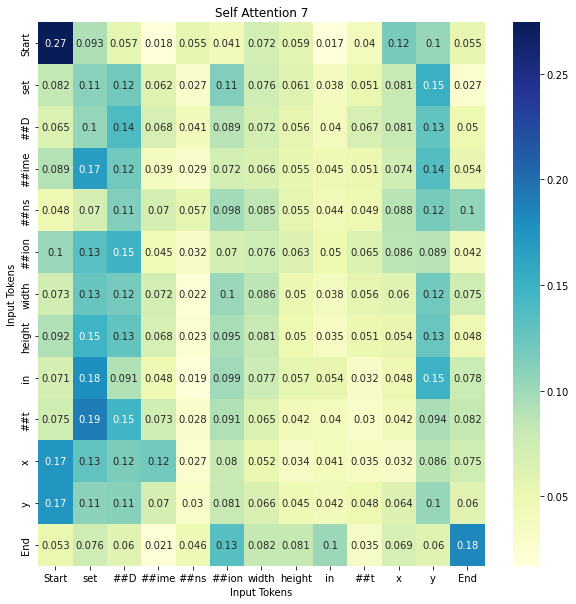

In [34]:
# Plot the attention heatmap for a single head
for i in range(len(attention_weights.squeeze().detach().numpy())):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(attention_weights.squeeze()[i].detach().numpy(), cmap='YlGnBu', annot=True, ax=ax,xticklabels=my_token, yticklabels=my_token)
    ax.set_title(f'Self Attention {i}')
    ax.set_xlabel("Input Tokens")
    ax.set_ylabel("Input Tokens")
    plt.show()

In [35]:
key.shape

torch.Size([1, 13, 384])

In [36]:
attention_weights.shape

torch.Size([1, 8, 13, 13])

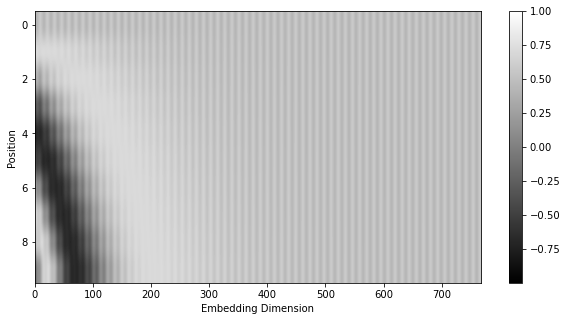

In [10]:
import numpy as np
import matplotlib.pyplot as plt

pos = np.arange(10)
d = 768
pe = np.zeros((len(pos), d))

for i in range(d // 2):
    pe[:, 2*i] = np.sin(pos / 10000**(2*i / d))
    pe[:, 2*i+1] = np.cos(pos / 10000**(2*i / d))

plt.figure(figsize=(10, 5))
plt.imshow(pe, cmap='gray', aspect='auto')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.colorbar()
plt.show()

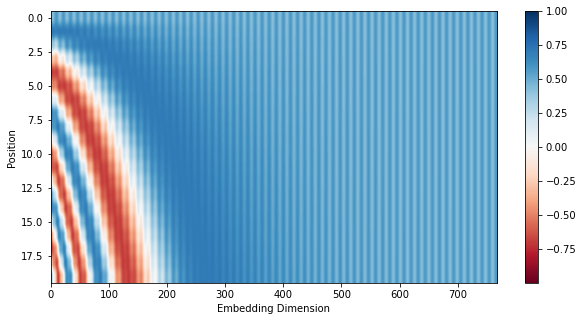

In [2]:
pos = np.arange(20)
d = 768
pe = np.zeros((len(pos), d))

for i in range(d // 2):
    pe[:, 2*i] = np.sin(pos / 10000**(2*i / d))
    pe[:, 2*i+1] = np.cos(pos / 10000**(2*i / d))

plt.figure(figsize=(10, 5))
plt.imshow(pe, cmap='RdBu', aspect='auto')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.colorbar()
plt.show()

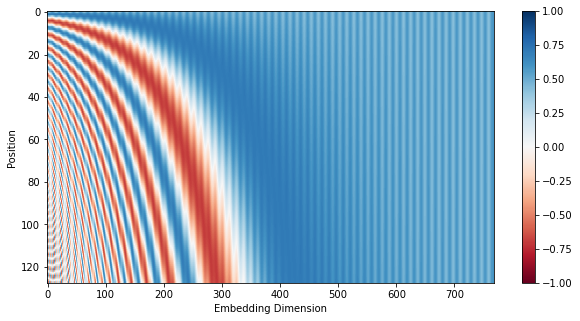

In [3]:
pos = np.arange(128)
d = 768
pe = np.zeros((len(pos), d))

for i in range(d // 2):
    pe[:, 2*i] = np.sin(pos / 10000**(2*i / d))
    pe[:, 2*i+1] = np.cos(pos / 10000**(2*i / d))

plt.figure(figsize=(10, 5))
plt.imshow(pe, cmap='RdBu', aspect='auto')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.colorbar()
plt.show()